In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.signal import fftconvolve
import dask.array as da
from pulse_pair_doppler import pulse_pair_doppler

In [2]:
model = pulse_pair_doppler(
    t_pulse=1.15e-4,                   # s
    t_receive=20e-4,                # s 
    t_interpulse=0*1e-4,              # s
    # n_reflectors=4,            # -    TODO why does this number increase error?
    # temporal_decorr = 0.98,
    n_pulses=2,                     # -
    n_bursts=35,                    # -
    bandwidth=1e6,                  # hz
    baseband=0,                     # hz   TODO why does this number increase error?
    oversample_retriev=1,           # -    TODO why does this number increase error?
    range_cell_avg_factor=1,        # -
    range_cell_size_frac_pulse=1,   # -
    seed=12,                         # -
)

model.chirp(centre_around_baseband=True).pulse_pairs()

pulse_pair_doppler(t_pulse=0.000115, t_receive=0.002, t_interpulse=0.0, n_pulses=2, n_bursts=35, bandwidth=1000000.0, baseband=0, seed=12, temporal_decorr=False, n_reflectors=None, oversample_retriev=1, range_cell_avg_factor=1, range_cell_size_frac_pulse=1)

In [3]:
# TODO fix chunk size at start
# TODO Have reflection be sampled at same temporal resolution as pulse
# TODO calculate pulses individually or somehow calculate reflection per pulse after groupby
# TODO calculate range and distance not from x and y, but of x and y and some array that adds a constant small offset per cell (mimicking that scatterers are not equally spaced)
# NOTE flox installed in environment to speed up groupby

In [4]:
c = 3e8
res_az = 150 # m   TODO find resolution along azimuth
res_rg = 150 # m   TODO make function of bandwith
n_scatterers_per_cell = 3
extent_rg = 600e3 # m 
extent_az = 50e3 # m
incidence_min = 29 # deg
x0, y0, z0 = 0, 0, 700e3 # m azimuth, range, altitude satellite
PRF = 5 # / s
distance_satellite = 25e3 # m 
vy_satellite, vx_satellite, vz_satellite = 0, 6800, 0 # m /s
n_bursts = int(np.floor(distance_satellite / vx_satellite * PRF))

n_scatterers_az = int(extent_az / res_az * n_scatterers_per_cell)
n_scatterers_rg = int(extent_rg / res_rg * n_scatterers_per_cell)

min_rg = np.tan(np.deg2rad(incidence_min))*z0
max_rg = min_rg + extent_rg
min_az, max_az = -extent_az/2, extent_az /2

seed = 42
np.random.seed(seed)
chunk_az = 50
chunk_rg = 50
chunk_time_slow = 1
chunk_pulse_time = -1

rg_extent = da.from_array(np.linspace(start=min_rg, stop=max_rg, num=n_scatterers_rg), chunks = (chunk_rg))
az_extent = da.from_array(np.linspace(start=min_az, stop=max_az, num=n_scatterers_az), chunks = (chunk_az))

rg, az = np.meshgrid(rg_extent, az_extent)

In [15]:
time_slow = np.linspace(start=0, stop=n_bursts/PRF ,num=n_bursts)
amplitude = da.from_array(np.random.rayleigh(scale=1, size=(rg.shape[0], rg.shape[1],  len(time_slow))), chunks=(chunk_az, chunk_rg, chunk_time_slow))
spatial_grid_offset_rg = da.from_array(np.random.uniform(low=-res_rg/2, high =res_rg/2, size= (rg.shape[0], rg.shape[1])), chunks=(chunk_az, chunk_rg))
spatial_grid_offset_az = da.from_array(np.random.uniform(low=-res_az/2, high =res_az/2, size= (rg.shape[0], rg.shape[1])), chunks=(chunk_az, chunk_rg))
uniform_phase = da.from_array(np.random.rand(amplitude.size).reshape(amplitude.shape), chunks = (chunk_az, chunk_rg, chunk_time_slow))
scatter_phase = np.exp(1j*uniform_phase*2*np.pi)
velocity = np.ones_like(amplitude)

x_sat = x0 + time_slow * vx_satellite
y_sat = y0 + time_slow * vy_satellite
z_sat = z0 + time_slow * vz_satellite

In [16]:
ds = xr.Dataset(
    data_vars=dict(
        amplitude=(["x", "y", "time_slow"], amplitude), 
        spatial_grid_offset_rg=(["x", "y"], spatial_grid_offset_rg), 
        spatial_grid_offset_az=(["x", "y"], spatial_grid_offset_az), 
        velocity=(["x", "y", "time_slow"], velocity),
        scatter_phase=(["x", "y", "time_slow"], scatter_phase),
        # TODO add beam pattern 
        # TODO add realistic gradient based on CMOD
        x_sat=(["time_slow"], x_sat),
        y_sat=(["time_slow"], y_sat),
        z_sat=(["time_slow"], z_sat),

    ),
    coords=dict(
        rg=(["x", "y"], rg),
        az=(["x", "y"], az),
        time_slow=(["time_slow"], time_slow),
    ),
    attrs=dict(description="Simulated surface", 
               vx_sat=vx_satellite, 
))
ds

<xarray.Dataset>
Dimensions:                 (x: 1000, y: 12000, time_slow: 18)
Coordinates:
    rg                      (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    az                      (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
  * time_slow               (time_slow) float64 0.0 0.2118 0.4235 ... 3.388 3.6
Dimensions without coordinates: x, y
Data variables:
    amplitude               (x, y, time_slow) float64 dask.array<chunksize=(50, 50, 1), meta=np.ndarray>
    spatial_grid_offset_rg  (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    spatial_grid_offset_az  (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    velocity                (x, y, time_slow) float64 dask.array<chunksize=(50, 50, 1), meta=np.ndarray>
    scatter_phase           (x, y, time_slow) complex128 dask.array<chunksize=(50, 50, 1), meta=np.ndarray>
    x_sat                   (time_slow) float64 0.0 1.44e+03 ... 2.448e+04
    y_sat                   (time_slow) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    z_sat                   (time_slow) float64 7e+05 7e+05 ... 7e+05 7e+05
Attributes:
    description:  Simulated surface
    vx_sat:       6800

In [14]:
pulse_time = xr.DataArray(np.linspace(0, model.t_pulse, model.pulse_samples), dims='pulse_time').chunk({'pulse_time':chunk_pulse_time})
pulse = xr.DataArray(model.pulse, dims='pulse_time').chunk({'pulse_time':chunk_pulse_time})

In [18]:
def calculate_distance(x, y, x0=0 , y0=0, x_offset=0, y_offset=0):
    return np.sqrt((x - x0 + x_offset) ** 2 + (y - y0 + y_offset) ** 2)

ds['d_ground'] = calculate_distance(ds['az'], ds['rg'], ds['x_sat'], ds['y_sat'], ds['spatial_grid_offset_az'], ds['spatial_grid_offset_rg'])
ds['R'] = calculate_distance(ds['d_ground'], ds['z_sat'])

pulse_time = xr.DataArray(np.linspace(0, model.t_pulse, model.pulse_samples), dims='pulse_time').chunk({'pulse_time':chunk_pulse_time})
pulse = xr.DataArray(model.pulse, dims='pulse_time').chunk({'pulse_time':chunk_pulse_time})

travel_time = ds['R']/c
t_min = travel_time.min().values*1
t_max = travel_time.max().values*1 + model.t_pulse
n_reflection_samples = int(np.ceil((t_max - t_min)*model.fs))
bins = np.linspace(t_min, t_max, n_reflection_samples)

ds['fast_time'] = travel_time + pulse_time
ds['reflection'] = ds['amplitude'] * ds['scatter_phase'] * pulse 
ds = ds.chunk({'x': chunk_az, 'y': chunk_rg, 'time_slow': chunk_time_slow, 'pulse_time':chunk_pulse_time})
ds

c:\Users\oweno\miniconda3\envs\env_stereoid\Lib\site-packages\dask\array\core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 18
  result = blockwise(
c:\Users\oweno\miniconda3\envs\env_stereoid\Lib\site-packages\dask\array\core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 18
  result = blockwise(


<xarray.Dataset>
Dimensions:                 (x: 1000, y: 12000, time_slow: 18, pulse_time: 230)
Coordinates:
    rg                      (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    az                      (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
  * time_slow               (time_slow) float64 0.0 0.2118 0.4235 ... 3.388 3.6
Dimensions without coordinates: x, y, pulse_time
Data variables:
    amplitude               (x, y, time_slow) float64 dask.array<chunksize=(50, 50, 1), meta=np.ndarray>
    spatial_grid_offset_rg  (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    spatial_grid_offset_az  (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    velocity                (x, y, time_slow) float64 dask.array<chunksize=(50, 50, 1), meta=np.ndarray>
    scatter_phase           (x, y, time_slow) complex128 dask.array<chunksize=(50, 50, 1), meta=np.ndarray>
    x_sat                   (time_slow) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    y_sat                   (time_slow) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    z_sat                   (time_slow) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    d_ground                (x, y, time_slow) float64 dask.array<chunksize=(50, 50, 1), meta=np.ndarray>
    R                       (x, y, time_slow) float64 dask.array<chunksize=(50, 50, 1), meta=np.ndarray>
    fast_time               (x, y, time_slow, pulse_time) float64 dask.array<chunksize=(50, 50, 1, 230), meta=np.ndarray>
    reflection              (x, y, time_slow, pulse_time) complex128 dask.array<chunksize=(50, 50, 1, 230), meta=np.ndarray>
Attributes:
    description:  Simulated surface
    vx_sat:       6800

In [19]:
new_dtype = 'float32'

# Create a new Dataset with the modified datatypes
ds = xr.Dataset({
    k: (v.astype('complex64') if v.dtype == 'complex128' else v.astype(new_dtype))
    for k, v in ds.data_vars.items()
})

In [20]:
ds = ds.isel(time_slow=range(0,2), y=range(0,12000), x=range(0,100))
ds

<xarray.Dataset>
Dimensions:                 (x: 100, y: 12000, time_slow: 2, pulse_time: 230)
Coordinates:
    rg                      (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    az                      (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
  * time_slow               (time_slow) float64 0.0 0.2118
Dimensions without coordinates: x, y, pulse_time
Data variables:
    amplitude               (x, y, time_slow) float32 dask.array<chunksize=(50, 50, 1), meta=np.ndarray>
    spatial_grid_offset_rg  (x, y) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    spatial_grid_offset_az  (x, y) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    velocity                (x, y, time_slow) float32 dask.array<chunksize=(50, 50, 1), meta=np.ndarray>
    scatter_phase           (x, y, time_slow) complex64 dask.array<chunksize=(50, 50, 1), meta=np.ndarray>
    x_sat                   (time_slow) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    y_sat                   (time_slow) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    z_sat                   (time_slow) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    d_ground                (x, y, time_slow) float32 dask.array<chunksize=(50, 50, 1), meta=np.ndarray>
    R                       (x, y, time_slow) float32 dask.array<chunksize=(50, 50, 1), meta=np.ndarray>
    fast_time               (x, y, time_slow, pulse_time) float32 dask.array<chunksize=(50, 50, 1, 230), meta=np.ndarray>
    reflection              (x, y, time_slow, pulse_time) complex64 dask.array<chunksize=(50, 50, 1, 230), meta=np.ndarray>

In [11]:
# import dask.distributed
# client = dask.distributed.Client()
# client

In [16]:
# ds["index_digi"] = (["x", "y", "time_slow", "pulse_time"], da.digitize(ds["fast_time"].data, bins).astype('int32'))

In [20]:
# ds["index_digi"] = da.digitize(ds["fast_time"].data, bins).astype('int32').chunk({'x': chunk_az, 'y': chunk_rg, 'time_slow': chunk_time_slow, 'pulse_time':chunk_pulse_time})

In [21]:
# def searchsort_custom(da, bins):
#     return np.searchsorted(bins, da)

# ds["index_digi"] = ds[["fast_time"]].apply(searchsort_custom, bins=bins).fast_time.astype('int32').chunk({'x': chunk_az, 'y': chunk_rg, 'time_slow': chunk_time_slow, 'pulse_time':chunk_pulse_time})

In [21]:
# ds_sub = ds.isel(time_slow=0)
# reflections_grouped = ds_sub['reflection'].groupby(ds_sub['index_digi'])
# reflection_total = reflections_grouped.sum().compute()

ds = ds[['reflection', 'fast_time']].isel(time_slow=0, y=range(0,100))
grouped = ds.groupby_bins(group = ds['fast_time'], bins= bins).sum().compute()
total_reflection = grouped.reflection


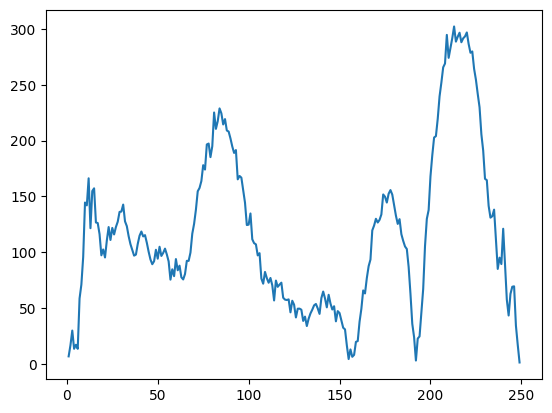

In [22]:
plt.plot(abs(total_reflection))

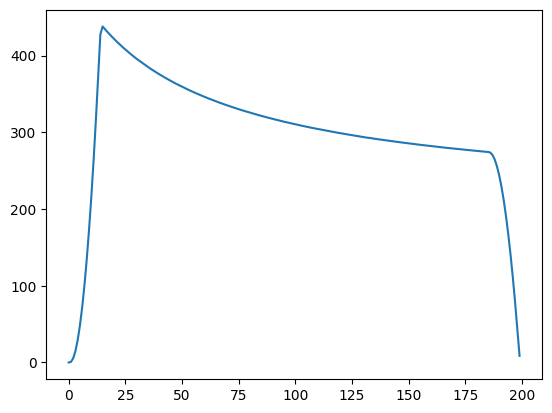

In [ ]:
plt.plot(reflection_total)

## Test without numpy

In [82]:
pulse = np.linspace(1, 200, 200)
from scipy.signal import fftconvolve

data_variable = ds['amplitude']
kernel_variable = ds['pulse']

convolved_data = xr.apply_ufunc(
    fftconvolve,
    data_variable,
    kernel_variable,
    input_core_dims=[['x', 'y', 'time_slow'], ['time_fast']],
    output_core_dims=[['x', 'y', 'time_slow', 'time_fast']],
    vectorize=True,
    dask='parallelized',  # Use Dask for parallel processing if available
    output_dtypes=[float],
    output_sizes={
        'x': len(data_variable['x']),
        'y': len(data_variable['y']),
        'time_slow': len(data_variable['time_slow']),
        'time_fast': len(kernel_variable['time_fast']),
    }
)